In [1]:
import os
import sys 
import glob
import dask
import pyproj
import copy
import dask
import xsar
import xrft
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr

import dask.array as da
import cmcrameri.cm as cmc
import drama.utils as drtls
from drama.performance.sar.antenna_patterns import sinc_bp, phased_array

from dataclasses import dataclass
from typing import Callable, Union, List, Dict, Any
from velocity_leakage import S1DopplerLeakage

In [2]:
# importing from one directory  up
sys.path.insert(0, "../" )
from misc import round_to_hour, angular_difference, calculate_distance

In [3]:
data_dir = "/Users/opodriscoll/Documents/Data/Sentinel1/IW/"
scenarios = glob.glob(f"{data_dir}*")
scenarios = [scenario[scenario.rfind('/')+1:] for scenario in scenarios]
scenarios = [ scenario for scenario in scenarios if "_" != scenario[0] ] 
scenarios.sort()
scenarios

['Aghulas_20190515',
 'Aghulas_20191110',
 'Aghulas_20200121',
 'Aghulas_20200321',
 'Aghulas_20200402',
 'Aghulas_20200414',
 'Aghulas_20200426',
 'Azores_20201127',
 'Barbedos_20201110',
 'Brasilia_20200321',
 'Brasilia_20200402',
 'Carrib_20231104',
 'Hawaii_20201106',
 'Iceland_20231107',
 'Morroco_20201022',
 'Morroco_20201103',
 'Morroco_20201115',
 'Scotland_20231109']

## Brasilia 

In [184]:
scenario = 'Brasilia_20200402'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6_800,
    PRF=4,
    grid_spacing=150,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern='phased_array',
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=30,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = None,
    )

test.apply()

/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/velocity_leakage.py:177: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Brasilia_20200402/1B62_403E_6D05_9071_A1CB_A3B0_C28B_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_20200402h0900_lat-7_89_lon-46_24.nc


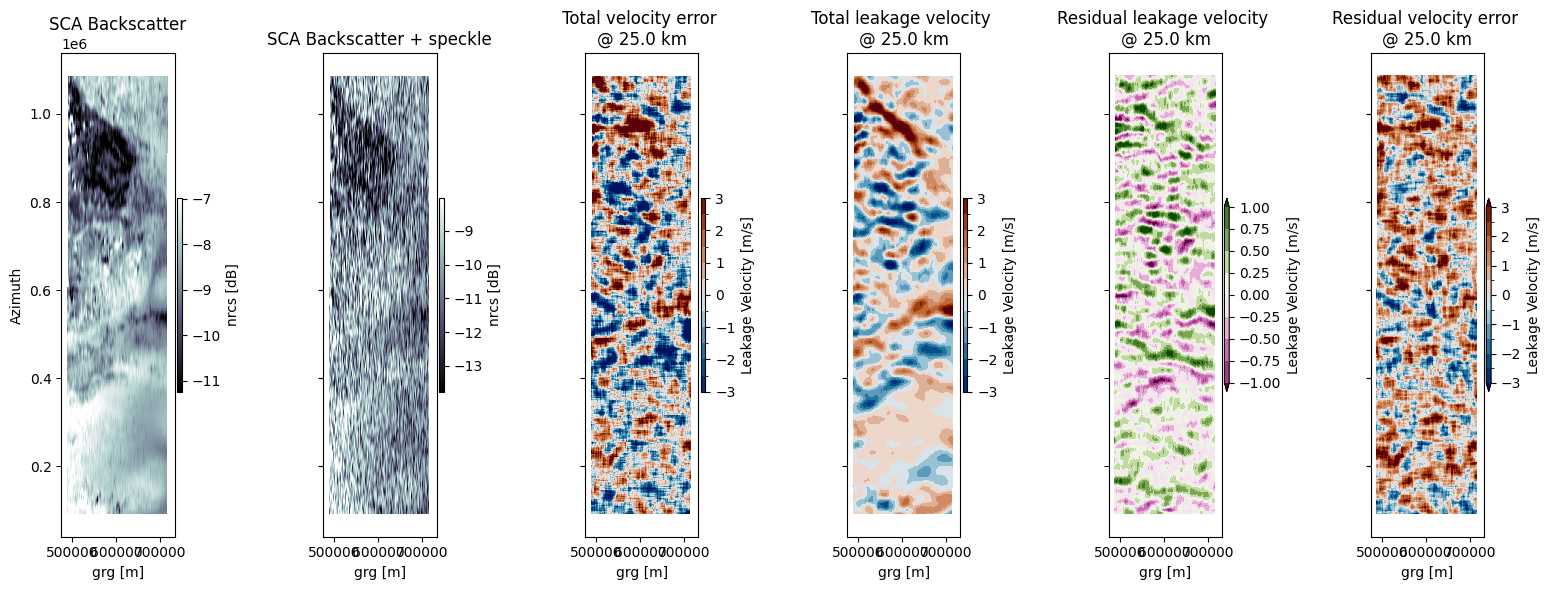

In [185]:
cbar_kwargs = {'shrink':0.4, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -3, 'vmax': 3, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 6; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (16, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)

plot_cut = net_velocity_error / net_velocity_error

(10*np.log10(test.data.nrcs_scat * plot_cut)).T.plot(ax= axes[*axes_indexes[0]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(10*np.log10(test.data.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
                                                  **{'cmap': 'bone', **plot_kwargs},
                                                  cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(test.data.V_sigma_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[2]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(test.data.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[3]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_leakage.T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_velocity_error.T.plot.contourf(ax= axes[*axes_indexes[5]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})

res = test.resolution_product/1000
titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [191]:
subset_domain = dict(slow_time = slice(1E5, 10.5E5), grg = slice(5.25E5, 7E5))

subset = test.data.sel(subset_domain)
factor_equal_to_one = test.data.V_leakage_pulse_rg/test.data.V_leakage_pulse_rg
pulse_pair_only = (factor_equal_to_one *test.velocity_error * np.random.randn(*test.data.V_leakage_pulse_rg.shape)).rolling(grg=test.grg_N, slow_time=test.slow_time_N, center=True).mean()

subset_net_leakage = subset.V_leakage_pulse_rg_subscene - subset.V_leakage_pulse_rg_subscene_inverted
subset_pulse_pair_only = pulse_pair_only.sel(subset_domain)
subset_net_velocity = subset.V_sigma_subscene - subset.V_leakage_pulse_rg_subscene_inverted

In [205]:
window = 'boxcar'
P_net_leakage = xrft.power_spectrum(
    da = subset_net_leakage,
    dim = 'slow_time',
    scaling = 'spectrum',
    detrend = 'constant',
    window = window,
    window_correction = 'True'
    )

P_pulse_pair = xrft.power_spectrum(
    da = subset_pulse_pair_only,
    dim = 'slow_time',
    scaling = 'spectrum',
    detrend = 'constant',
    window = window,
    window_correction = 'True'
    )

P_net_velocity = xrft.power_spectrum(
    da = subset_net_velocity,
    dim = 'slow_time',
    scaling = 'spectrum',
    detrend = 'constant',
    window = window,
    window_correction = 'True'
    )

def one_sided(P, dim = 'freq_slow_time'):
    positive_freqs = P[dim] >0
    P = 2 * P.loc[:, positive_freqs]
    x = P[dim]
    return P, x


P_net_leakage_os, chi_net_leakage_os = one_sided(P_net_leakage)
P_pulse_pair_os, chi_pulse_pair_os = one_sided(P_pulse_pair)
P_net_velocity_os, chi_net_velocity_os = one_sided(P_net_velocity)

P_net_leakage_mean, P_net_leakage_std = P_net_leakage_os.mean(dim = 'grg'), P_net_leakage_os.std(dim = 'grg')
P_pulse_pair_mean, P_pulse_pair_std = P_pulse_pair_os.mean(dim = 'grg'), P_pulse_pair_os.std(dim = 'grg')
P_net_velocity_mean,P_net_velocity_std = P_net_velocity_os.mean(dim = 'grg'), P_net_velocity_os.std(dim = 'grg')

In [206]:
print(np.var(subset_net_leakage), P_net_leakage_mean.sum())
print(np.var(subset_pulse_pair_only), P_pulse_pair_mean.sum())
print(np.var(subset_net_velocity), P_net_velocity_mean.sum())

<xarray.DataArray ()> Size: 8B
array(0.16032216) <xarray.DataArray ()> Size: 8B
array(0.16029626)
<xarray.DataArray 'V_leakage_pulse_rg' ()> Size: 8B
array(1.75327593) <xarray.DataArray ()> Size: 8B
array(1.70060767)
<xarray.DataArray ()> Size: 8B
array(1.94088723) <xarray.DataArray ()> Size: 8B
array(1.91702986)


In [207]:
freq_threshold = 1/80_000
freqs = slice(0, freq_threshold)
relative_variance_increase = 100*((P_net_velocity_mean.sel(freq_slow_time = freqs).sum()/P_pulse_pair_mean.sel(freq_slow_time = freqs).sum()).values-1)

print(f"Variance at scales greater than {1/freq_threshold:.2f} m increases by {relative_variance_increase:.2f}%")

Variance at scales greater than 80000.00 m increases by 25.75%


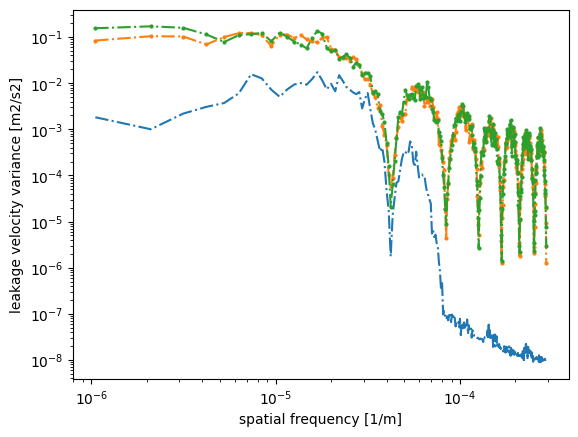

In [204]:
markersize  = 2
linestyle = '-.'
marker = 'o'
plt.plot(chi_net_leakage_os, P_net_leakage_mean, linestyle = linestyle)
plt.plot(chi_pulse_pair_os, P_pulse_pair_mean, marker=marker,linestyle =linestyle, markersize=markersize)
plt.plot(chi_net_velocity_os, P_net_velocity_mean, marker=marker,linestyle =linestyle, markersize=markersize)
plt.xlabel('spatial frequency [1/m]')
plt.ylabel('leakage velocity variance [m2/s2]')
plt.xscale('log');  plt.yscale('log')

## Morroco 

In [168]:
scenario = 'Morroco_20201103'
files = glob.glob(f"{data_dir+scenario}/*.SAFE")

test = S1DopplerLeakage(
    filename=files,
    # f0=26.5e9,
    z0 = 823_000,
    era5_directory='era5_winds/',
    resolution_product=25_000,
    az_footprint_cutoff=80_000,
    vx_sat=6_800,
    PRF=4,
    grid_spacing=150,
    antenna_length=2.87,
    antenna_height=0.32,
    beam_pattern='phased_array',
    antenna_elements=4,
    antenna_weighting=0.75,
    swath_start_incidence_angle_scat=30,
    boresight_elevation_angle_scat=40,
    random_state = 42,
    fill_nan_limit = None,
    )

test.apply()

/Users/opodriscoll/Documents/Scripts/DopSCA/Sentinel1_analyses/velocity_leakage.py:177: UserWarning: Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0
  warnings.warn("Combination of vx_sat, PRF and grid_spacing may lead to aliasing: (vx_sat / PRF) % grid_spacing != 0")


Associated file found and reloaded: /Users/opodriscoll/Documents/Data/Sentinel1/IW/Morroco_20201103/0831_0B4E_2DB3_3597_6475_966E_BC59_D53C_res150.nc
Loading nearest ERA5 point w.r.t. observation from ERA5 file: era5_winds/era5_wind_202011.nc


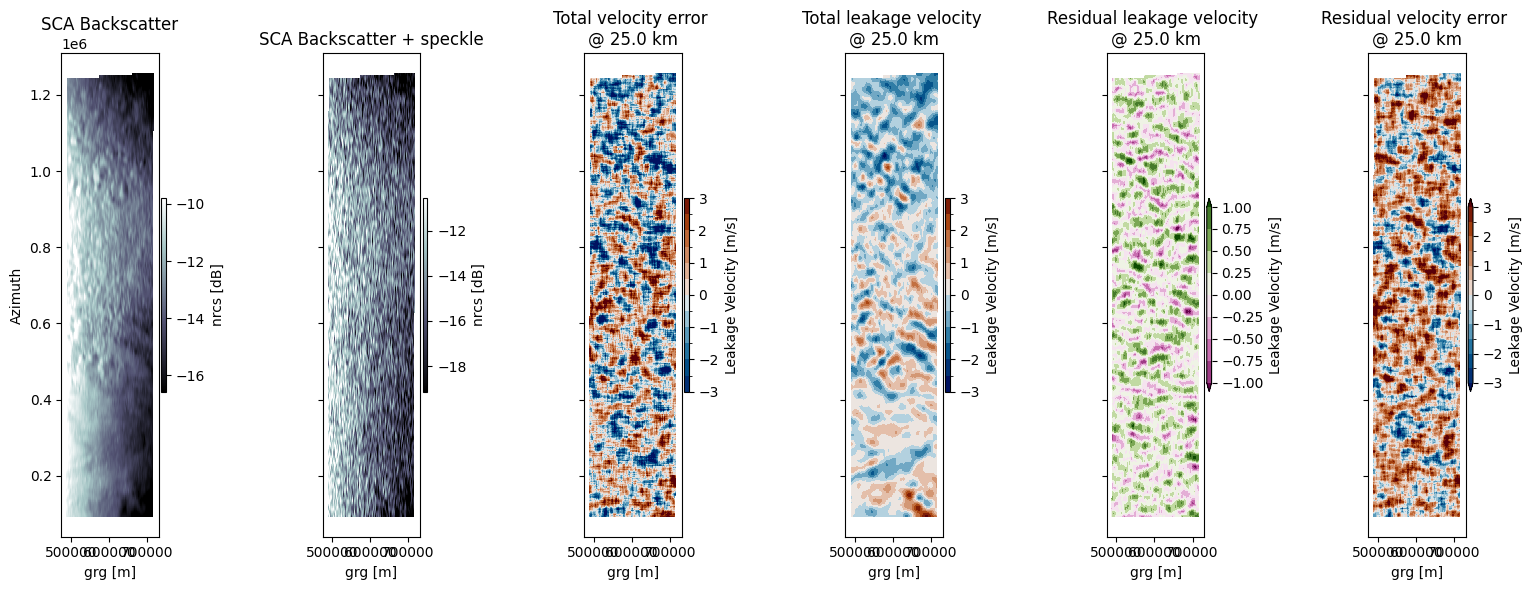

In [169]:
cbar_kwargs = {'shrink':0.4, 'aspect':40, 'pad' : 0.01, 'extend':'neither'}
plot_kwargs = {'robust': True}
plot_leakage_kwargs = {'vmin': -3, 'vmax': 3, 'cmap' : cmc.vik, 'levels' : 13}
plot_leakage_net_kwargs = {'vmin': -1, 'vmax': 1, 'cmap' : cmc.bam, 'levels' : 9}
label_kwargs = {'xlabel':'Range [m]', 'ylabel':'Azimuth [m]'}

net_leakage = test.data.V_leakage_pulse_rg_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
net_velocity_error =  test.data.V_sigma_subscene - test.data.V_leakage_pulse_rg_subscene_inverted
nx = 6; ny = 1
fig, axes = plt.subplots(ny, nx, figsize = (16, 6), sharex=True, sharey=True)
axes_indexes = np.argwhere(axes)

plot_cut = net_velocity_error / net_velocity_error

(10*np.log10(test.data.nrcs_scat * plot_cut)).T.plot(ax= axes[*axes_indexes[0]],#[0,0], 
                                          **{'cmap': 'bone', **plot_kwargs},
                                          cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(10*np.log10(test.data.nrcs_scat_w_noise * plot_cut)).T.plot(ax= axes[*axes_indexes[1]],#[0,1], 
                                                  **{'cmap': 'bone', **plot_kwargs},
                                                  cbar_kwargs = {'label':'nrcs [dB]', **cbar_kwargs})
(test.data.V_sigma_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[2]],#[0,2], 
                                             **{**plot_leakage_kwargs, **plot_kwargs},
                                             cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
(test.data.V_leakage_pulse_rg_subscene * plot_cut).T.plot(ax= axes[*axes_indexes[3]],#[1,0],
                    **{**plot_leakage_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_leakage.T.plot.contourf(ax= axes[*axes_indexes[4]],#[1,1],
                    **{**plot_leakage_net_kwargs, **plot_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})
net_velocity_error.T.plot.contourf(ax= axes[*axes_indexes[5]],#[1,2],
                    **{**plot_leakage_net_kwargs, **plot_leakage_kwargs},
                    cbar_kwargs = {'label':'Leakage Velocity [m/s]', **cbar_kwargs})

res = test.resolution_product/1000
titles = ['SCA Backscatter', 'SCA Backscatter + speckle', f'Total velocity error \n@ {res:2} km', 
          f'Total leakage velocity \n@ {res:2} km', f'Residual leakage velocity \n@ {res:2} km', f'Residual velocity error \n@ {res:2} km']
x_labels = [''] * (nx * np.max([0, ny-1])) + ['Range [m]'] * (nx * (ny-1))
y_labels = (['Azimuth'] + [''] * (nx - 1)) * ny
_ = [ax.axes.set_title(i) for ax, i in zip(axes.ravel(), titles)]
_ = [ax.axes.set_xlabel(i) for ax, i in zip(axes.ravel(), x_labels)]
_ = [ax.axes.set_ylabel(i) for ax, i in zip(axes.ravel(), y_labels)]
_ = [ax.axes.set_aspect('equal') for ax in axes.ravel()]

plt.tight_layout()

In [177]:
subset_domain = dict(slow_time = slice(1E5, 12E5), grg = slice(5.25E5, 7E5))
# subset_domain = dict(slow_time = slice(1.5E5, 5.5E5), grg = slice(5.25E5, 7E5))
subset = test.data.sel(subset_domain)
factor_equal_to_one = test.data.V_leakage_pulse_rg/test.data.V_leakage_pulse_rg
pulse_pair_only = (factor_equal_to_one *test.velocity_error * np.random.randn(*test.data.V_leakage_pulse_rg.shape)).rolling(grg=test.grg_N, slow_time=test.slow_time_N, center=True).mean()

subset_net_leakage = subset.V_leakage_pulse_rg_subscene - subset.V_leakage_pulse_rg_subscene_inverted
subset_pulse_pair_only = pulse_pair_only.sel(subset_domain)
subset_net_velocity = subset.V_sigma_subscene - subset.V_leakage_pulse_rg_subscene_inverted

In [180]:
P_net_leakage = xrft.power_spectrum(
    da = subset_net_leakage,
    dim = 'slow_time',
    scaling = 'spectrum',
    detrend = 'constant',
    window = 'boxcar',
    window_correction = 'True'
    )

P_pulse_pair = xrft.power_spectrum(
    da = subset_pulse_pair_only,
    dim = 'slow_time',
    scaling = 'spectrum',
    detrend = 'constant',
    window = 'boxcar',
    window_correction = 'True'
    )

P_net_velocity = xrft.power_spectrum(
    da = subset_net_velocity,
    dim = 'slow_time',
    scaling = 'spectrum',
    detrend = 'constant',
    window = 'boxcar',
    window_correction = 'True'
    )

def one_sided(P, dim = 'freq_slow_time'):
    positive_freqs = P[dim] >0
    P = 2 * P.loc[:, positive_freqs]
    x = P[dim]
    return P, x


P_net_leakage_os, chi_net_leakage_os = one_sided(P_net_leakage)
P_pulse_pair_os, chi_pulse_pair_os = one_sided(P_pulse_pair)
P_net_velocity_os, chi_net_velocity_os = one_sided(P_net_velocity)

P_net_leakage_mean, P_net_leakage_std = P_net_leakage_os.mean(dim = 'grg'), P_net_leakage_os.std(dim = 'grg')
P_pulse_pair_mean, P_pulse_pair_std = P_pulse_pair_os.mean(dim = 'grg'), P_pulse_pair_os.std(dim = 'grg')
P_net_velocity_mean,P_net_velocity_std = P_net_velocity_os.mean(dim = 'grg'), P_net_velocity_os.std(dim = 'grg')

In [181]:
print(np.var(subset_net_leakage), P_net_leakage_mean.sum())
print(np.var(subset_pulse_pair_only), P_pulse_pair_mean.sum())
print(np.var(subset_net_velocity), P_net_velocity_mean.sum())

<xarray.DataArray ()> Size: 8B
array(0.11388368) <xarray.DataArray ()> Size: 8B
array(0.11388843)
<xarray.DataArray 'V_leakage_pulse_rg' ()> Size: 8B
array(1.78429639) <xarray.DataArray ()> Size: 8B
array(1.74450102)
<xarray.DataArray ()> Size: 8B
array(2.00898689) <xarray.DataArray ()> Size: 8B
array(1.9609092)


In [182]:
freq_threshold = 1/80_000
freqs = slice(0, freq_threshold)
relative_variance_increase = 100*((P_net_velocity_mean.sel(freq_slow_time = freqs).sum()/P_pulse_pair_mean.sel(freq_slow_time = freqs).sum()).values-1)

print(f"Variance at scales greater than {1/freq_threshold:.2f} m increases by {relative_variance_increase:.2f}%")

Variance at scales greater than 80000.00 m increases by 11.38%


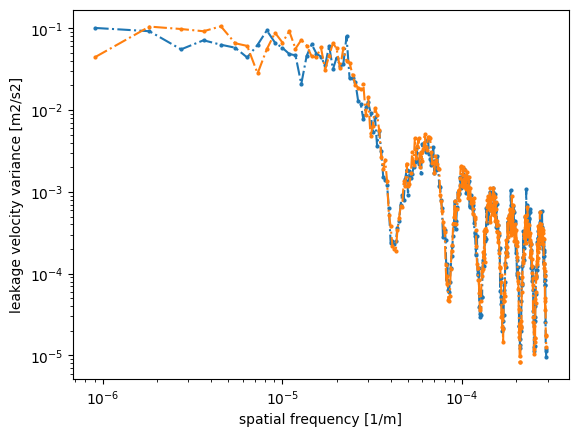

In [183]:
markersize  = 2
linestyle = '-.'
marker = 'o'
# plt.plot(chi_net_leakage_os, P_net_leakage_mean, linestyle = linestyle)
plt.plot(chi_pulse_pair_os, P_pulse_pair_mean, marker=marker,linestyle =linestyle, markersize=markersize)
plt.plot(chi_net_velocity_os, P_net_velocity_mean, marker=marker,linestyle =linestyle, markersize=markersize)
plt.xlabel('spatial frequency [1/m]')
plt.ylabel('leakage velocity variance [m2/s2]')
plt.xscale('log');  plt.yscale('log')